In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
import matplotlib.pyplot as plt
import os
import numpy as np

In [3]:
omp = 1
mpi = 4

In [4]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt')
#code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',scheduler='slurm',sbatch_options=['--partition=all12h'])

Initialize a Yambo calculator with scheduler direct


In [5]:
# Common parameters (eventually overwritten by the dictionary values)
fwhm = 100 #fs
scissor = 0.5409 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as

# RT analysis of the spin dynamics

In this notebook we analyze the dynamics of the spin polarization.

## Analysis of a single pulse in various cases

Here we perform some simulations with a single guassian pulse for both a single and
multiple k points sampling. We also test the functionality of the _boost_ that allows us
to speed up the calculations setting to zero the $\rho_{cv}$ elements of the density matrix.

The relevant parameters of the various simulations are organized in a dictionary

In [7]:
simulations = {
    'gamma': {
        'source_dir' : 'NSCF/sampling_gamma.save',
        'run_dir' : 'RT_gamma', 
        'field_int' : 1e3,
        'field_eng' : 1.42,
        'sim_time'  : 2000,
        'eta'       : 2e-3,
        'no_sym'    : False,
        'bands'     : [5,10],
        'skip'      : True,
        'saveGtime' : False
    },
    'singlek_high-freq': {
        'source_dir' : 'NSCF/sampling_1k-maxfreq.save',
        'run_dir' : 'RT_singlek_high-freq',
        'field_int' : 1e3,
        'field_eng' : 1.531,
        'sim_time'  : 10000,
        'eta'       : 2e-3,
        'no_sym'    : False,
        'bands'     : [7,10],
        'skip'      : True,
        'saveGtime' : False
    },
    'singlek_high-freq_boost': {
        'source_dir' : 'NSCF/sampling_1k-maxfreq.save',
        'run_dir' : 'RT_singlek_high-freq',
        'field_int' : 1e3,
        'field_eng' : 1.531,
        'sim_time'  : 10000,
        'eta'       : 2e-3,
        'no_sym'    : False,
        'bands'     : [7,10],
        'skip'      : True,
        'saveGtime' : False,
        'boost'     : {'dTupdateTimeSet' : [500,'fs'], 'dT_SET' : [20,'']}
    },
    'k100_random_boost': {
        'source_dir' : 'NSCF/num_k_100-sampling_random_kspan0.05.save',
        'run_dir' : 'RT_k100_random',
        'field_int' : 1e3,
        'field_eng' : 1.5,
        'sim_time'  : 10000,
        'eta'       : 2e-3,
        'no_sym'    : False,
        'bands'     : [5,10],
        'skip'      : True,
        'saveGtime' : False,
        'boost'     : {'dTupdateTimeSet' : [500,'fs'], 'dT_SET' : [20,'']}
    },
    'k100_random_boost_Ghistory': {
        'source_dir' : 'NSCF/num_k_100-sampling_random_kspan0.05.save',
        'run_dir' : 'RT_k100_random',
        'field_int' : 1e3,
        'field_eng' : 1.5,
        'sim_time'  : 10000,
        'eta'       : 2e-3,
        'no_sym'    : False,
        'bands'     : [5,10],
        'skip'      : True,
        'saveGtime' : True,
        'io_time'   : [1.0,50.0,10.0], # I/O (CARRIERs - GF - OUTPUT) in fs
        'boost'     : {'dTupdateTimeSet' : [500,'fs'], 'dT_SET' : [20,'']}
    }
}

In [8]:
#simulations

### Construction of the SAVE folder and FixSymm procedure

In [9]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,overwrite_if_found=False)
        U.make_FixSymm(run_dir,polarization='circular',Efield1=[1.,0.,0.],Efield2=[0.,1.,0.],overwrite_if_found=False)
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for gamma
SAVE folder already present in RT_gamma. No operations performed.
SAVE folder already present in RT_gamma/FixSymm. No operations performed.
 
build SAVE and perform FixSymm for singlek_high-freq
SAVE folder already present in RT_singlek_high-freq. No operations performed.
SAVE folder already present in RT_singlek_high-freq/FixSymm. No operations performed.
 
build SAVE and perform FixSymm for singlek_high-freq_boost
SAVE folder already present in RT_singlek_high-freq. No operations performed.
SAVE folder already present in RT_singlek_high-freq/FixSymm. No operations performed.
 
build SAVE and perform FixSymm for k100_random_boost
SAVE folder already present in RT_k100_random. No operations performed.
SAVE folder already present in RT_k100_random/FixSymm. No operations performed.
 
build SAVE and perform FixSymm for k100_random_boost_Ghistory
SAVE folder already present in RT_k100_random. No operations performed.
SAVE folder already present in R

### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations, 
the others are taken from the dictionary.

The input are added to the simulations dict.

In [10]:
io_time = [1.0,10.0,10.0] # I/O (CARRIERs - GF - OUTPUT) in fs

In [12]:
for pars in simulations.values():
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],fwhm=fwhm,polarization='circular',freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=pars['bands'],scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',io_time=io_time,time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='carriers obs'  # do not write ndb.carriers and ndb.RT_observables on disk
    rt_input['arguments'].append('SPINprojected') # compute the projection of the spin polarization in conduction
    rt_input['arguments'].append('DephCVonly') # enable the dephasing only for cv transitions
    if pars['saveGtime']:
        rt_input['arguments'].append('SaveGhistory') # save the Glesser in functions of the time
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    if pars.get('io_time') is not None:
        rt_input['variables']['IOtime'] = [pars['io_time'],'fs']
    if pars.get('boost') is not None:
        rt_input['variables'].update(pars['boost'])
    pars['input'] = rt_input

In [18]:
#simulations['k100_random_boost_Ghistory']

In [19]:
study = D.Dataset(num_tasks=1)
study.set_postprocessing_function(D.PostProcessing.yambo_parse_data)

Initialize a Dataset with 1 parallel tasks


In [20]:
for id,sim in simulations.items():
    study.append_run(id=id,input=sim['input'],run_dir=sim['rt_run_dir'],runner=code,skip=sim['skip'])

In [21]:
#study.ids

In [22]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0], [1], [2], [3], [4]] 

Run the task [0] 
Skip the run of gamma
Task [0] ended 

Run the task [1] 
Skip the run of singlek_high-freq
Task [1] ended 

Run the task [2] 
Skip the run of singlek_high-freq_boost
Task [2] ended 

Run the task [3] 
Skip the run of k100_random_boost
Task [3] ended 

Run the task [4] 
run command: cd RT_k100_random/FixSymm; mpirun -np 4 yambo_rt -F k100_random_boost_Ghistory.in -J k100_random_boost_Ghistory -C k100_random_boost_Ghistory
computation k100_random_boost_Ghistory is running...
computation k100_random_boost_Ghistory ended
Task [4] ended 



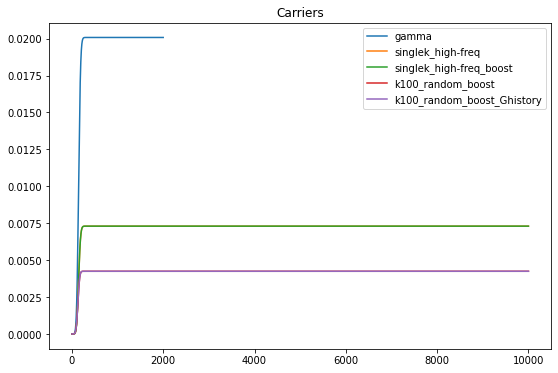

In [23]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['carriers']['time']
    dne = r.data['carriers']['dne']
    plt.plot(t,dne,label=D.name_from_id(study.ids[ind]))
    plt.title('Carriers')
    plt.legend()

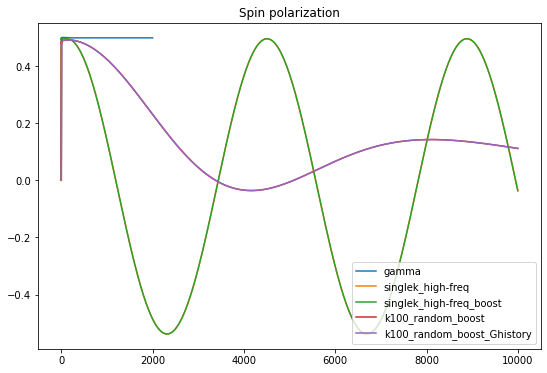

In [24]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['spin_magnetization']['time']
    pz = r.data['spin_magnetization']['Mc_z']
    plt.plot(t,pz,label=D.name_from_id(study.ids[ind]))
    plt.title('Spin polarization')
    plt.legend()

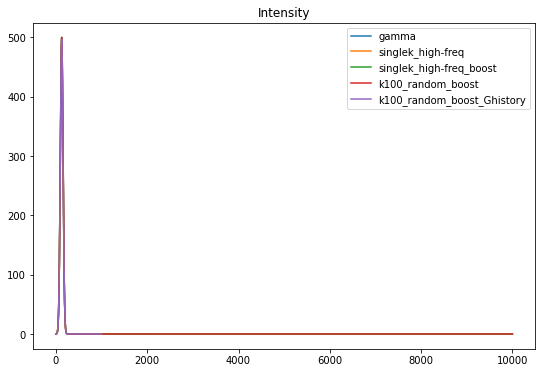

In [18]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['external_field']['time']
    Int = r.data['external_field']['Intensity']
    plt.plot(t,Int,label=D.name_from_id(study.ids[ind]))
    plt.title('Intensity')
    plt.legend()
    #plt.ylim(-0.1,2)
    #plt.show()

## Analysis of a single k point with the THz pulse

In [69]:
from mppi.Models import TwoLevelSystems as TLS

We study the dynamics of the single k point (we choose the singlek_high_freq case) and apply
a THz pulse after the optical pump.

Due to the Fixsymm we are actually dealing with 48 k points, the energy gap it is the same for 
all of them but the coupling dipole changes. We choose the intensity of the THz pulse such that
the $\pi$ condition is realized on the first of the k points.

In [70]:
run_dir = 'RT_singlek_high-freq/FixSymm'
out_dir = 'RT_singlek_high-freq/FixSymm/singlek_high-freq_boost'

In [71]:
ref = P.YamboParser.from_path(run_dir,out_dir)

Parse file RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/o-singlek_high-freq_boost.current
Parse file RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/o-singlek_high-freq_boost.spin_magnetization
Parse file RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/o-singlek_high-freq_boost.external_field
Parse file RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/o-singlek_high-freq_boost.orbt_magnetization
Parse file RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/o-singlek_high-freq_boost.polarization
Parse file RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/o-singlek_high-freq_boost.carriers
Parse file : RT_singlek_high-freq/FixSymm/SAVE/ns.db1
Parse file : RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/ndb.dipoles
Parse file : RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/ndb.RT_G_PAR


We compute the energy gap of the conduction states

In [72]:
de_ccp = 1e3*ref.dft.get_transitions(initial=[8,9],final=[8,9])[0][0]
de_ccp # in meV

0.9444647438892062

In [73]:
numk = len(ref.dipoles.dip_ir)
numk

48

We build an array with the matrix elements $x_{cc'}$ for all the k points

In [74]:
x_dipole = ref.dipoles.r_dipole(0,first_band=2)
x_dipole[0]

array([[ 0.         +0.j        , 15.27632319+22.94874198j],
       [15.27632319-22.94874198j,  0.         +0.j        ]])

We set the FWH of the THz pulse

In [75]:
THz_fwhm =  20 #ps

We compute the value of the field intensity that produces the $\pi$ conditions on the first k point.  
To do so we extract the equivalent of th $\mu_{12}$ transition dipole defined in the theory of the TLS.

In [76]:
theta = np.pi
pars = TLS.pulseParametersFromTheta(x_dipole[0,0,1],theta,fwhm=THz_fwhm,THz_pulse=True)
#pars

time unit: ps
the width parameter of the pulse is 8.493218002880191 ps
Rabi coupling (ps^-1): (0.08177049377812073+0.12283911124034695j)
Rabi coupling (module) (ps^-1): 0.14756646266356058
field amplitude (V/m): 66579.79073343561
field intensity (kW/cm^2) : 1.1766689276495992


In [77]:
THz_int = 1.1767 
T_delay = 1 # ps

In [78]:
simulations = {
    'echo_THz_pi': {
        'source_dir' : 'NSCF/sampling_1k-maxfreq.save',
        'run_dir' : 'RT_singlek_high-freq',
        'fields'  : [dict(index=1,int=1000,freq=1.531,fwhm=fwhm,polarization='circular'),
                     dict(index=2,int=THz_int,freq=de_ccp,freq_units='meV',fwhm=THz_fwhm,fwhm_units='ps',
                          tstart=T_delay,tstart_units='ps')],
        'sim_time'  : 80*1e3,
        'eta'       : 2e-3,
        'no_sym'    : False,
        'bands'     : [7,10],
        'skip'      : True,
        'boost'     : {'dTupdateTimeSet' : [500,'fs'], 'dT_SET' : [10,'']}
    }
}

In [79]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,overwrite_if_found=False)
        U.make_FixSymm(run_dir,polarization='circular',Efield1=[1.,0.,0.],Efield2=[0.,1.,0.],overwrite_if_found=False)
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for echo_THz_pi
SAVE folder already present in RT_singlek_high-freq. No operations performed.
SAVE folder already present in RT_singlek_high-freq/FixSymm. No operations performed.
 
mv RT_singlek_high-freq/FixSymm/SAVE/ns.kb_pp_pwscf RT_singlek_high-freq/FixSymm/SAVE/ns.kb_pp_pwscf_hide


In [80]:
io_time = [1.0,10.0,10.0] # I/O (CARRIERs - GF - OUTPUT) in fs

In [81]:
for pars in simulations.values():
    rt_input = I.YamboInput('yambo_rt -n p2 -v ip -V rt',folder=pars['rt_run_dir'])
    for f in pars['fields']:
        rt_input.set_rt_field(**f)
    rt_input.set_rt_bands(bands=pars['bands'],scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',io_time=io_time,time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='carriers obs'  # do not write ndb.carriers and ndb.RT_observables on disk
    rt_input['arguments'].append('SPINprojected') # compute the projection of the spin polarization in conduction
    rt_input['arguments'].append('DephCVonly') # enable the dephasing only for cv transitions
    rt_input['arguments'].append('SaveGhistory') # save the Glesser in functions of the time
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    if pars.get('boost') is not None:
        rt_input['variables'].update(pars['boost'])
    pars['input'] = rt_input

In [82]:
#simulations

In [83]:
study = D.Dataset(num_tasks=1)
study.set_postprocessing_function(D.PostProcessing.yambo_parse_data)

Initialize a Dataset with 1 parallel tasks


In [84]:
for id,sim in simulations.items():
    study.append_run(id=id,input=sim['input'],run_dir=sim['rt_run_dir'],runner=code,skip=sim['skip'])

In [85]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of echo_THz_pi
Task [0] ended 



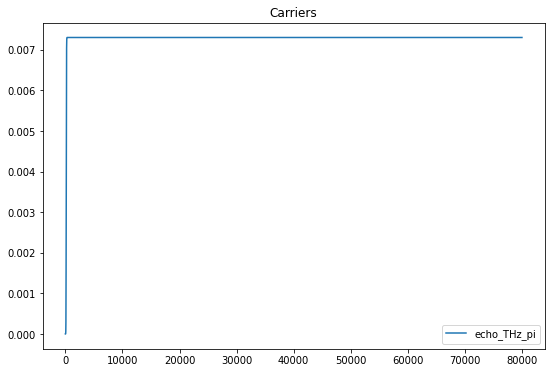

In [86]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['carriers']['time']
    dne = r.data['carriers']['dne']
    plt.plot(t,dne,label=D.name_from_id(study.ids[ind]))
    plt.title('Carriers')
    plt.legend()

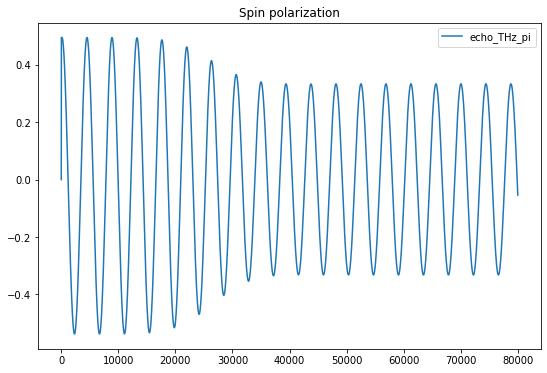

In [88]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['spin_magnetization']['time']
    pz = r.data['spin_magnetization']['Mc_z']
    plt.plot(t,pz,label=D.name_from_id(study.ids[ind]))
    plt.title('Spin polarization')
    plt.legend()
    #plt.show()

In [89]:
#results[0].get_info()

### Density matrix and Bloch vector

In [90]:
study.ids

['echo_THz_pi']

In [91]:
sim = 0

We build the time dependent density matrix in the conduction sector. The equilibrium density matrix in this sector
vanishes so we do not need to add id

In [97]:
green = results[sim].RTGreen
dm = green.buildDensityMatrix(first_band=2)
ntimes = len(dm) # dimension of the time index
nk = len(dm[0]) # dimension of the index
dm.shape

(16003, 48, 2, 2)

In [98]:
dm[100,0]

array([[0.00362593+0.j        , 0.00246917+0.00258965j],
       [0.00246917-0.00258965j, 0.00381121+0.j        ]])

We define a time variable that convert the time index of the density matrix in
the effective simulation time

In [99]:
NETime = 80e3
time = np.linspace(0,NETime,ntimes)
time.shape

(16003,)

From the dm we can compute the number of carriers in function of time

In [100]:
trace_cc = np.trace(dm,axis1=2,axis2=3) #trace in the conduction sector
carriers = np.mean(trace_cc,axis=1) # average over k

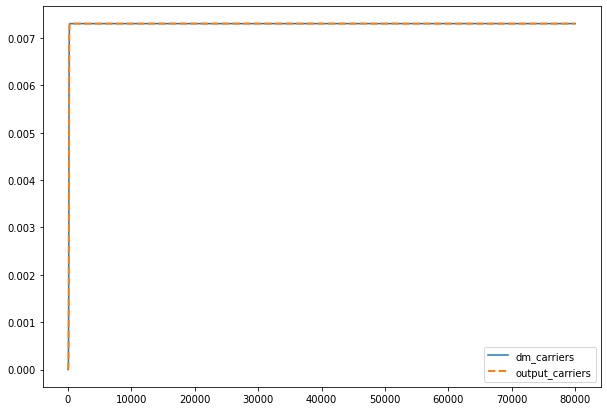

In [101]:
plt.figure(figsize=(10,7))
plt.plot(time,carriers.real,label='dm_carriers')
results_time = results[sim].data['carriers']['time']
dne = results[sim].data['carriers']['dne']
plt.plot(results_time,dne,label='output_carriers',linestyle='--',linewidth=2)
plt.legend()

We can compute also the expectation value of the spin polarization and compare with the one
provided in the output files

We compute the matrix elements of the spin operator

In [103]:
spin_dipole = results[sim].dipoles.spin_dipole(2,first_band=2)
spin_dipole.shape

(48, 2, 2)

Then we compute the expectation value of the degree of the spin polarization (z component),
by dividing the expectation value of Sz and the number of carriers

In [104]:
Sz = np.mean(np.trace(np.matmul(dm,spin_dipole),axis1=2,axis2=3),axis=1).real
Pz = np.true_divide(Sz,carriers.real,where=carriers.real!=0)

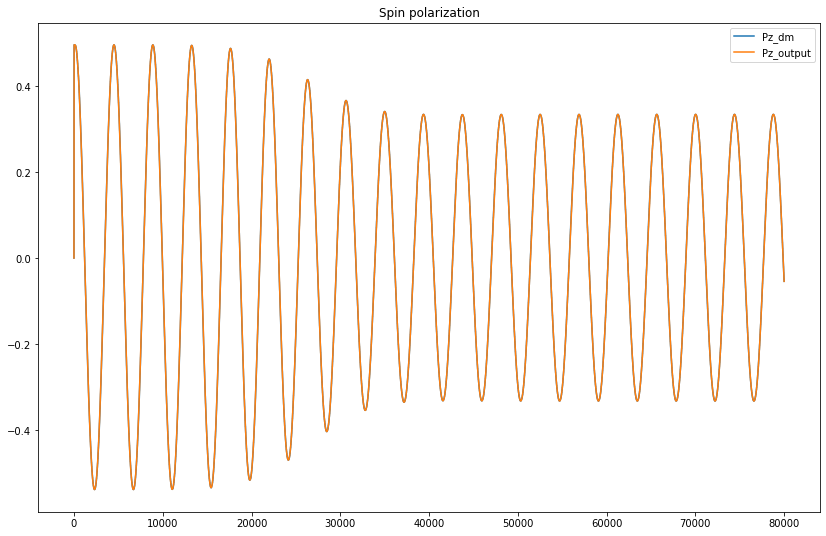

In [105]:
plt.figure(figsize=(14,9))
plt.plot(time,Pz,label='Pz_dm')
res_time = results[sim].data['spin_magnetization']['time']
Pz_out = results[sim].data['spin_magnetization']['Mc_z']
plt.plot(res_time,Pz_out,label='Pz_output')
plt.title('Spin polarization')
plt.legend()

We build the Bloch vector from the density matrix

In [106]:
Bloch = P.buildBlochVectors(dm)
Bloch.shape

(3, 16003, 48)

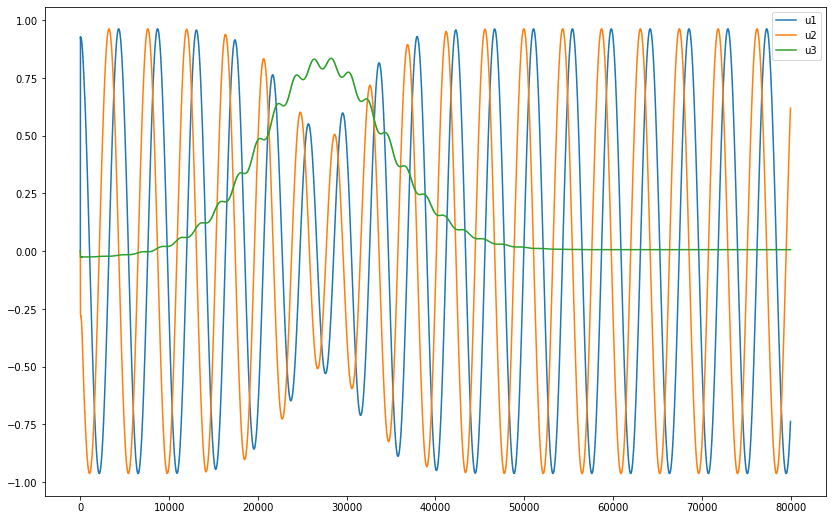

In [107]:
k = 1
plt.figure(figsize=(14,9))
plt.plot(time,Bloch[0,:,k],label='u1')
plt.plot(time,Bloch[1,:,k],label='u2')
plt.plot(time,Bloch[2,:,k],label='u3')
plt.legend()

Lastly, we can compute the degree of spin polarization using the Bloch vectors. Note that the Bloch vectors
are normalized to one for each $k$ and $t$.

Assuming that the Sz operator has diagonal elements with opposite values $(Sz_{00}=-Sz_{11})$
we can express the expectation value of $S_z$ as
$$
S_z(k,t) = \mathrm{Tr}_{cc'}(\rho(k,t)\left(
u_{3}(k,t)Sz_{00}(k)+u_1(k,t)Re(Sz_{10}(k))+u_2(k,t)Im(Sz_{10}(k)\right) 
$$
Then, the degree of spin polarization is defined as
$$
P_z(t) = \frac{\mathrm{Tr}_{k} \left(S_z(k,t)\right)}{\mathrm{Tr}_{cc'k}(\rho(k,t)}
$$

In [108]:
Rsz10 = spin_dipole[:,1,0].real
Isz10 = spin_dipole[:,1,0].imag
sz00 = spin_dipole[:,0,0].real
Sz_k_bloch = (Bloch[0]*Rsz10+Bloch[1]*Isz10+Bloch[2]*sz00)*trace_cc
Sz_bloch = np.mean(Sz_k_bloch,axis=1)
Pz_bloch = np.true_divide(Sz_bloch,carriers,where=carriers != 0).real

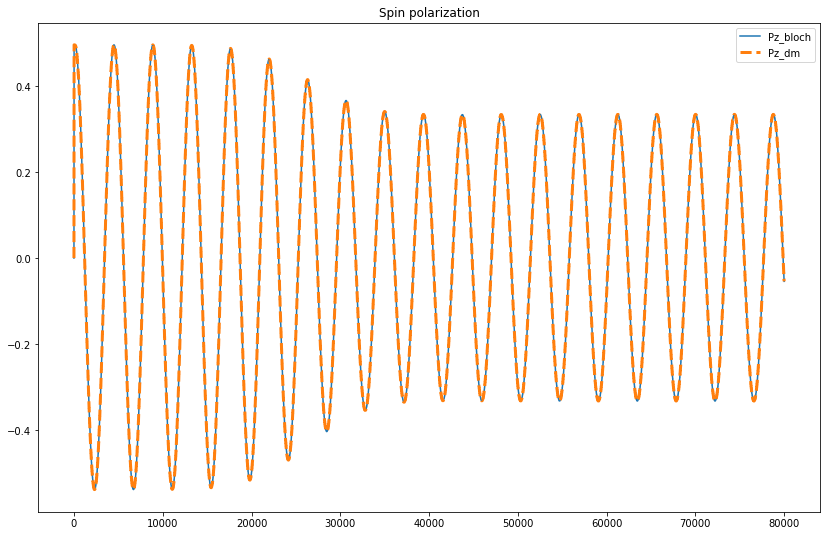

In [109]:
plt.figure(figsize=(14,9))
plt.plot(time,Pz_bloch,label='Pz_bloch')
plt.plot(time,Pz,label='Pz_dm',linestyle='--',linewidth=3)
plt.title('Spin polarization')
#plt.xlim(0,5999)
plt.legend()

## Analysis of a single k point with the THz pulse detuned with respect to the gap

In [20]:
from mppi.Models import TwoLevelSystems as TLS
from mppi.Models import GaussianPulse as G

We study the dynamics of the single k point (we choose the singlek_high_freq case) and apply
a THz pulse after the optical pump. The energy of the pulse is sligthly w.r.t the energy gap of the 
conduction band to study the dynamics of the spin polarization in this case

Due to the Fixsymm we are actually dealing with 48 k points, the energy gap it is the same for 
all of them but the coupling dipole changes. We choose the intensity of the THz pulse such that
the $\pi$ condition is realized on the first of the k points.

In [9]:
run_dir = 'RT_singlek_high-freq/FixSymm'
out_dir = 'RT_singlek_high-freq/FixSymm/singlek_high-freq_boost'

In [10]:
ref = P.YamboParser.from_path(run_dir,out_dir)

Parse file RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/o-singlek_high-freq_boost.current
Parse file RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/o-singlek_high-freq_boost.spin_magnetization
Parse file RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/o-singlek_high-freq_boost.external_field
Parse file RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/o-singlek_high-freq_boost.orbt_magnetization
Parse file RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/o-singlek_high-freq_boost.polarization
Parse file RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/o-singlek_high-freq_boost.carriers
Parse file : RT_singlek_high-freq/FixSymm/SAVE/ns.db1
Parse file : RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/ndb.dipoles
Parse file : RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/ndb.RT_G_PAR


We compute the energy gap of the conduction states

In [11]:
de_ccp = 1e3*ref.dft.get_transitions(initial=[8,9],final=[8,9])[0][0]
de_ccp # in meV

0.9444647438892062

In [12]:
numk = len(ref.dipoles.dip_ir)
numk

48

We build an array with the matrix elements $x_{cc'}$ for all the k points

In [13]:
x_dipole = ref.dipoles.r_dipole(0,first_band=2)
x_dipole[0]

array([[ 0.         +0.j        , 15.27632319+22.94874198j],
       [15.27632319-22.94874198j,  0.         +0.j        ]])

We set the FWH of the THz pulse

In [14]:
THz_fwhm =  20 #ps

We compute the value of the field intensity that produces the $\pi$ conditions on the first k point.  
To do so we extract the equivalent of th $\mu_{12}$ transition dipole defined in the theory of the TLS.

In [23]:
theta = np.pi
pars = TLS.pulseParametersFromTheta(x_dipole[0,0,1],theta,fwhm=THz_fwhm,THz_pulse=True)
#pars

time unit: ps
the width parameter of the pulse is 8.493218002880191 ps
Rabi coupling (ps^-1): (0.08177049377812073+0.12283911124034695j)
Rabi coupling (module) (ps^-1): 0.14756646266356058
field amplitude (V/m): 66579.79073343561
field intensity (kW/cm^2) : 1.1766689276495992


In [58]:
THz_int = 1.1767
THz_ampl = 66580
T_delay = 1 # ps

We build the THz pulse and study its energy spread

In [59]:
NETime = 200 # in ps (used only to compute the FT)
ntimes = 10000
time = np.linspace(0,NETime,ntimes) #
T_delay = 1

In [60]:
pulse = G.gaussianPulse(time,energy=de_ccp,amplitude=THz_ampl,fwhm=THz_fwhm,THz_pulse=True,t_start=T_delay,envelope_only=False)

time unit: ps - energy unit: meV
period of the oscillations 4.378848150754763 ps
width of the pulse 8.493218002880191 ps
fwhm of the pulse 20 ps


In [61]:
energies,pulse_ft = G.evalPulseFourierTransform(time,pulse,THz_pulse=True)

time unit: ps - energy unit: meV
energy resolution of the FT: 0.020676270646151997 meV
maximum energy: 103.36067696011384 meV
FWHM of the FT of the pulse: 0.16541016516921603 meV


(0.0, 2.0)

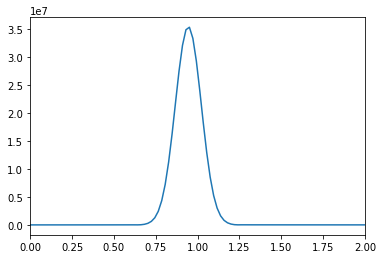

In [62]:
plt.plot(energies,pulse_ft)
plt.xlim(0,2)

We choose the energy of the THz pulse at 0.8 meV

In [63]:
simulations = {
    'echo_THz_pi_detuned': {
        'source_dir' : 'NSCF/sampling_1k-maxfreq.save',
        'run_dir' : 'RT_singlek_high-freq',
        'fields'  : [dict(index=1,int=1000,freq=1.531,fwhm=fwhm,polarization='circular'),
                     dict(index=2,int=THz_int,freq=0.8,freq_units='meV',fwhm=THz_fwhm,fwhm_units='ps',
                          tstart=T_delay,tstart_units='ps')],
        'sim_time'  : 80*1e3,
        'eta'       : 2e-3,
        'no_sym'    : False,
        'bands'     : [7,10],
        'skip'      : True,
        'boost'     : {'dTupdateTimeSet' : [500,'fs'], 'dT_SET' : [10,'']}
    }
}

In [64]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,overwrite_if_found=False)
        U.make_FixSymm(run_dir,polarization='circular',Efield1=[1.,0.,0.],Efield2=[0.,1.,0.],overwrite_if_found=False)
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for echo_THz_pi_detuned
SAVE folder already present in RT_singlek_high-freq. No operations performed.
SAVE folder already present in RT_singlek_high-freq/FixSymm. No operations performed.
 
mv RT_singlek_high-freq/FixSymm/SAVE/ns.kb_pp_pwscf RT_singlek_high-freq/FixSymm/SAVE/ns.kb_pp_pwscf_hide


In [65]:
io_time = [1.0,10.0,10.0] # I/O (CARRIERs - GF - OUTPUT) in fs

In [66]:
for pars in simulations.values():
    rt_input = I.YamboInput('yambo_rt -n p2 -v ip -V rt',folder=pars['rt_run_dir'])
    for f in pars['fields']:
        rt_input.set_rt_field(**f)
    rt_input.set_rt_bands(bands=pars['bands'],scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',io_time=io_time,time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='carriers obs'  # do not write ndb.carriers and ndb.RT_observables on disk
    rt_input['arguments'].append('SPINprojected') # compute the projection of the spin polarization in conduction
    rt_input['arguments'].append('DephCVonly') # enable the dephasing only for cv transitions
    rt_input['arguments'].append('SaveGhistory') # save the Glesser in functions of the time
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    if pars.get('boost') is not None:
        rt_input['variables'].update(pars['boost'])
    pars['input'] = rt_input

In [67]:
#simulations

In [68]:
study = D.Dataset(num_tasks=1)
study.set_postprocessing_function(D.PostProcessing.yambo_parse_data)

Initialize a Dataset with 1 parallel tasks


In [69]:
for id,sim in simulations.items():
    study.append_run(id=id,input=sim['input'],run_dir=sim['rt_run_dir'],runner=code,skip=sim['skip'])

In [70]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete folder: RT_singlek_high-freq/FixSymm/echo_THz_pi_detuned
run command: cd RT_singlek_high-freq/FixSymm; mpirun -np 4 yambo_rt -F echo_THz_pi_detuned.in -J echo_THz_pi_detuned -C echo_THz_pi_detuned
computation echo_THz_pi_detuned is running...
computation echo_THz_pi_detuned ended
Task [0] ended 



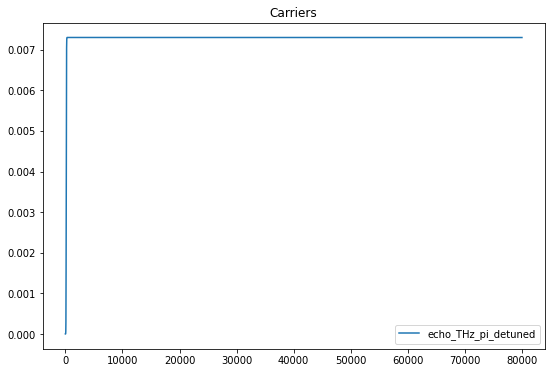

In [71]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['carriers']['time']
    dne = r.data['carriers']['dne']
    plt.plot(t,dne,label=D.name_from_id(study.ids[ind]))
    plt.title('Carriers')
    plt.legend()

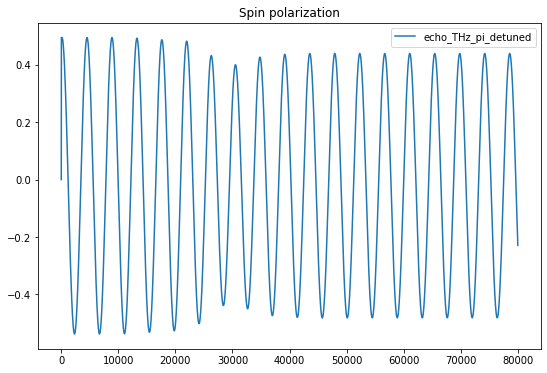

In [72]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    #plt.figure(figsize=(9,6))
    t = r.data['spin_magnetization']['time']
    pz = r.data['spin_magnetization']['Mc_z']
    plt.plot(t,pz,label=D.name_from_id(study.ids[ind]))
    plt.title('Spin polarization')
    plt.legend()
    #plt.show()

The Bloch vector can be compared with the results of the TLS analysis.